In [55]:
import yfinance as yf

In [56]:
#user_input
stock_symbol=str(input("Please enter the correct ticker name of the stock:"))

Please enter the correct ticker name of the stock:TCS.NS


In [57]:
print(stock_symbol)

TCS.NS


In [58]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [59]:
type(data)

pandas.core.frame.DataFrame

In [60]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-25,1288.5,1318.775024,1284.000000,1312.300049,1185.019897,4094094.0
2017-05-26,1312.5,1313.425049,1282.324951,1289.125000,1164.092285,1362550.0
2017-05-29,1289.5,1298.250000,1282.000000,1286.425049,1161.654419,1749290.0
2017-05-30,1280.0,1287.974976,1262.500000,1275.550049,1151.834106,927634.0
2017-05-31,1266.5,1286.250000,1264.000000,1273.300049,1149.802612,2502730.0


In [61]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-19,3397.000000,3405.000000,3230.000000,3261.949951,3240.124268,4642963.0
2022-05-20,3310.000000,3313.899902,3270.050049,3293.000000,3270.966553,3065125.0
2022-05-23,3304.800049,3338.899902,3267.000000,3321.750000,3299.524170,2293690.0
2022-05-24,3315.149902,3324.850098,3275.600098,3288.000000,3266.000000,1711510.0
2022-05-25,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
len(data)

1236

In [63]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

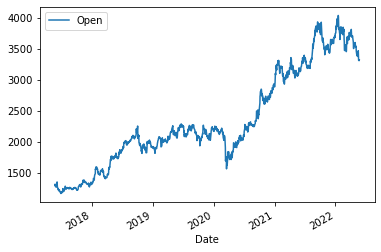

In [64]:
opn.plot()

In [65]:
from keras.models import load_model

In [66]:
import matplotlib.pyplot as plt

In [67]:
ds = opn.values

In [68]:
ds

array([[1288.5       ],
       [1312.5       ],
       [1289.5       ],
       ...,
       [3304.80004883],
       [3315.14990234],
       [          nan]])

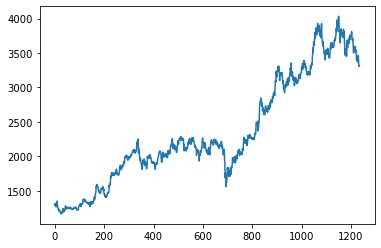

In [69]:
plt.plot(ds)

In [70]:
import numpy as np

In [71]:
#MinMaxScaler preserves the shape of the original distribution. It doesn't meaningfully change the information embedded in the original data. 
from sklearn.preprocessing import MinMaxScaler

In [72]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))


In [73]:
len(ds_scaled), len(ds)

(1236, 1236)

In [74]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [75]:
train_size,test_size

(865, 371)

In [76]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [77]:
len(ds_train),len(ds_test)

(865, 371)

In [78]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [79]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [80]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [81]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [82]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [83]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [84]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [85]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 10s 311ms/step - loss: 0.0196 - val_loss: 0.1135
Epoch 2/100
12/12 [==============================] - 2s 177ms/step - loss: 0.0040 - val_loss: 0.0207
Epoch 3/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0025 - val_loss: 0.0231
Epoch 4/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0015 - val_loss: 0.0164
Epoch 5/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 6/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 7/100
12/12 [==============================] - 2s 180ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 8/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 9/100
12/12 [==============================] - 2s 177ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 10/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0011 - val_l

Epoch 78/100
12/12 [==============================] - 2s 176ms/step - loss: 3.2106e-04 - val_loss: 6.2571e-04
Epoch 79/100
12/12 [==============================] - 2s 179ms/step - loss: 3.3523e-04 - val_loss: 0.0012
Epoch 80/100
12/12 [==============================] - 2s 180ms/step - loss: 3.6665e-04 - val_loss: 0.0015
Epoch 81/100
12/12 [==============================] - 2s 179ms/step - loss: 3.2487e-04 - val_loss: 8.8492e-04
Epoch 82/100
12/12 [==============================] - 2s 175ms/step - loss: 3.0043e-04 - val_loss: 8.6009e-04
Epoch 83/100
12/12 [==============================] - 2s 176ms/step - loss: 3.0809e-04 - val_loss: 5.7611e-04
Epoch 84/100
12/12 [==============================] - 2s 175ms/step - loss: 2.9494e-04 - val_loss: 5.4958e-04
Epoch 85/100
12/12 [==============================] - 2s 175ms/step - loss: 2.7595e-04 - val_loss: 6.2739e-04
Epoch 86/100
12/12 [==============================] - 2s 175ms/step - loss: 2.6896e-04 - val_loss: 7.5876e-04
Epoch 87/100
12/12

In [34]:
model.save('keras_model')

INFO:tensorflow:Assets written to: keras_model\assets


INFO:tensorflow:Assets written to: keras_model\assets


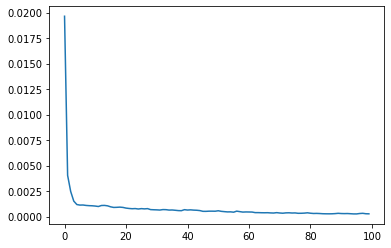

In [86]:
loss = model.history.history['loss']
plt.plot(loss)

In [87]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [88]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

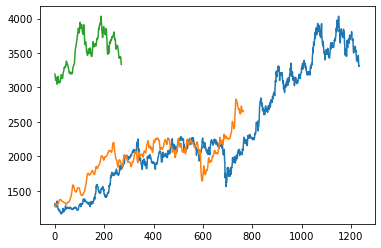

In [89]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [90]:
type(train_predict)

numpy.ndarray

In [91]:
test = np.vstack((train_predict,test_predict))

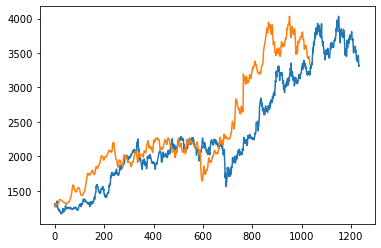

In [92]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [93]:
len(ds_test)

371

In [94]:
a=len(ds_test)

In [95]:
a

371

In [96]:
b=a-100

In [97]:
b

271

In [98]:
fut_inp = ds_test[b:]

In [99]:
fut_inp = fut_inp.reshape(1,-1)

In [100]:
fut_inp = fut_inp.reshape(1,-1)

In [101]:
tmp_inp = list(fut_inp)

In [102]:
fut_inp.shape

(1, 100)

In [103]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [104]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<5):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[nan], [nan], [nan], [nan], [nan]]


In [105]:
len(ds_scaled)

1236

In [106]:
lenth_of_ds_scaled=len(ds_scaled)-100

In [107]:
lenth_of_ds_scaled

1136

In [108]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,106)

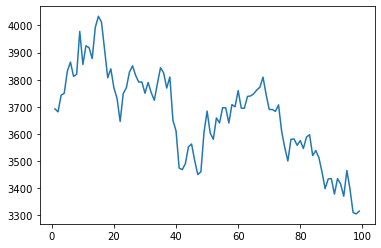

In [109]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[lenth_of_ds_scaled:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [110]:
ds_new = ds_scaled.tolist()
len(ds_new)

1236

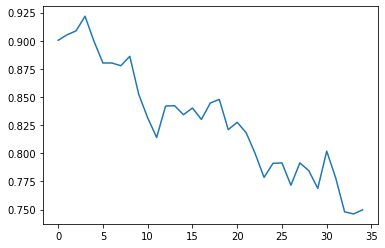

In [111]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [112]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

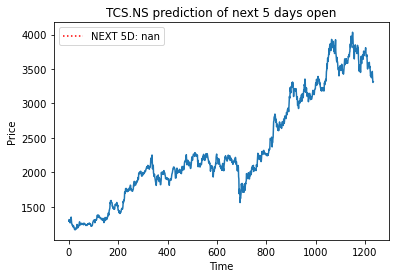

In [113]:
#Plotting final results with predicted value after 5 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next 5 days open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 5D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()